# Data Exploration on Netflix Prize Data

## Initialize

### Import Libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
%matplotlib inline
warnings.filterwarnings('ignore', category=FutureWarning)


In [2]:
# define the paths
data_path = '../data/NetflixPrize/'

### Read Data

In [3]:
df_test = pd.read_csv(data_path+'combined_data_1.txt',
                      names=['user_id', 'rating', 'date', 'movie_id'],
                      low_memory=False,
                      dtype={'user_id':str,
                             'rating':float,
                             'date':str,
                             'movie_id':float})
# df_test_2 = pd.read_csv(data_path+'combined_data_2.txt',names=['user_id', 'rating', 'date', 'movie_id'])
# df_test_3 = pd.read_csv(data_path+'combined_data_3.txt',names=['user_id', 'rating', 'date', 'movie_id'])
# df_test_4 = pd.read_csv(data_path+'combined_data_4.txt',names=['user_id', 'rating', 'date', 'movie_id'])
# df_test = pd.concat([df_test,df_test_2,df_test_3,df_test_4])


### Understanding the data

In [4]:
print(df_test.head())
print(df_test.tail())
print(df_test.shape)
print(df_test.columns)
print(df_test.isnull().sum().iloc[1])

   user_id  rating        date  movie_id
0       1:     NaN         NaN       NaN
1  1488844     3.0  2005-09-06       NaN
2   822109     5.0  2005-05-13       NaN
3   885013     4.0  2005-10-19       NaN
4    30878     4.0  2005-12-26       NaN
          user_id  rating        date  movie_id
24058258  2591364     2.0  2005-02-16       NaN
24058259  1791000     2.0  2005-02-10       NaN
24058260   512536     5.0  2005-07-27       NaN
24058261   988963     3.0  2005-12-20       NaN
24058262  1704416     3.0  2004-06-02       NaN
(24058263, 4)
Index(['user_id', 'rating', 'date', 'movie_id'], dtype='object')
4499


### Clean up data
From `df.head()`, we can see that the movies id are converted as `uid: movie_id` with `rating: NaN`, `date: NaN`, and `movie_id: NaN`, and the date haven't appeared. Therefore, we will modify the it to be 4 columns: `movie_id`, `user_id`, `rating`, `date`. In the next section, we can see that `df_test.isnull().sum().iloc[1]==m_movies`, implies that there will be no null value in the data if we just change the lines with `movie_id:` as follow:

In [5]:
# # Lets make a copy of the data first
# import shutil
# for i in range(1,5):
#   shutil.copyfile(data_path+f'combined_data_{i}.txt',data_path+f'data_{i}.txt')
# print('done')

In [6]:
# # Modify the the rows with 'movie_id:' to ',,,movie_id'
# import re

# pat = r'\d+:'
# def func(s):
#   if s.group():
#     return ',,,'+ s.group()[:-1]
#   else:
#     ''

# for i in range(1,5): 
#   with open(data_path+f"data_{i}.txt", mode="r+") as f:
#     content = f.read()
#     content = re.sub(pat,func,content)
#     f.seek(0)
#     f.write(content)
#     f.truncate()
    
# print('done')

### Load the new data

In [7]:
names = ['user_id','rating','date','movie_id']
# load data (comment df_2, df_3, df_4 and last line if you want to reduce the loading time)
df = pd.read_csv(data_path+'data_1.txt', names=names)
# df_2 = pd.read_csv(data_path+'data_2.txt', names=names)
# df_3 = pd.read_csv(data_path+'data_3.txt', names=names)
# df_4 = pd.read_csv(data_path+'data_4.txt', names=names)
# df = pd.concat([df,df_2,df_3,df_4], names=names)

In [8]:
df['movie_id'] = df['movie_id'].fillna(method='ffill')

# drop the rows with NaN 
df = df.dropna()

# change the datatypes 
df['rating'] = df['rating'].astype(int)
df['movie_id'] = df['movie_id'].astype(int)
df['user_id'] = df['user_id'].astype(int)
df['date'] = pd.to_datetime(df['date'])

## Understanding the data

In [9]:
df.head()

,user_id,rating,date,movie_id
1,1488844,3,2005-09-06,1
2,822109,5,2005-05-13,1
3,885013,4,2005-10-19,1
4,30878,4,2005-12-26,1
5,823519,3,2004-05-03,1


In [10]:
df.tail()

,user_id,rating,date,movie_id
24058258,2591364,2,2005-02-16,4499
24058259,1791000,2,2005-02-10,4499
24058260,512536,5,2005-07-27,4499
24058261,988963,3,2005-12-20,4499
24058262,1704416,3,2004-06-02,4499


In [11]:
df.shape

(24053764, 4)

In [12]:
# Note that it is not necessary to know the mean, std,... of user_id, movie_id because they are continuous.
df['rating'].describe()

count    2.405376e+07
mean     3.599634e+00
std      1.086118e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [13]:
df.columns

Index(['user_id', 'rating', 'date', 'movie_id'], dtype='object')

In [14]:
df.isnull().sum()

user_id     0
rating      0
date        0
movie_id    0
dtype: int64

In [15]:
m_movies = df['movie_id'].nunique()
n_users = df['user_id'].nunique()
n_ratings = len(df)
n_date = df['date'].nunique()
unique_rate = df['rating'].unique()


In [16]:
print("=== Const Values of the data ===")
print(f"Nnumber of movies: {m_movies}")
print(f"Number of users: {n_users}")
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique dates: {n_date}")
print(f"Users can rate movies with in {sorted(unique_rate)}")
print("=== End of Const Values of the data ===")

=== Const Values of the data ===
Nnumber of movies: 4499
Number of users: 470758
Number of ratings: 24053764
Number of unique dates: 2182
Users can rate movies with in [1, 2, 3, 4, 5]
=== End of Const Values of the data ===


## Relationship analysis

#### Correlation

In [17]:
correlation = df.corr()

<AxesSubplot:>

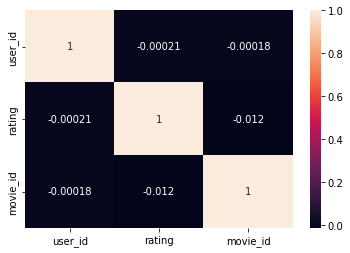

In [18]:
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns,annot=True)

#### Rating Analysis

In [19]:
df['rating'].describe()[1:]

mean    3.599634
std     1.086118
min     1.000000
25%     3.000000
50%     4.000000
75%     4.000000
max     5.000000
Name: rating, dtype: float64

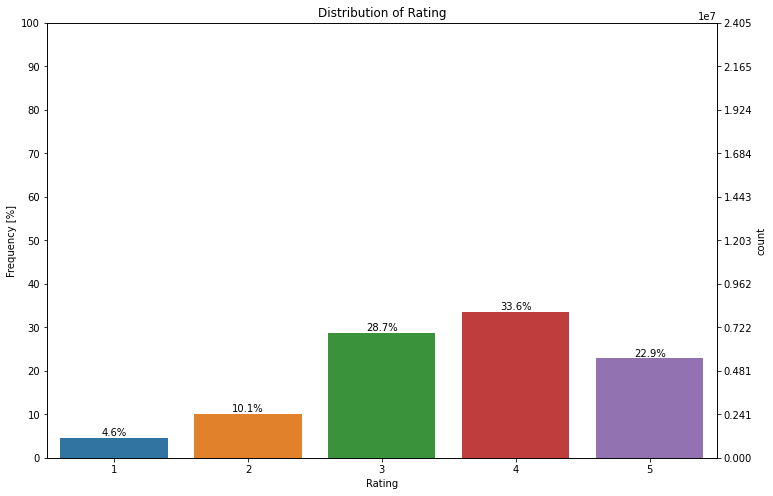

In [20]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='rating', data=df)
plt.title('Distribution of Rating')
plt.xlabel('Rating')

ax2 = ax.twinx()

ax2.yaxis.tick_left()
ax.yaxis.tick_right()

ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  ax.annotate('{:.1f}%'.format(100*y/n_ratings), (x.mean(), y), ha='center', va='bottom')

import matplotlib.ticker as ticker
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

ax2.set_ylim(0,100)
ax.set_ylim(0, n_ratings)

ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# ax2.grid(None)
plt.show()

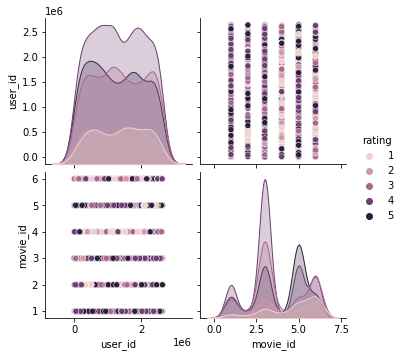

In [21]:
sns.pairplot(data=df[:5000],hue='rating')

In [22]:
group_by_user = df.groupby('user_id')
group_by_movie = df.groupby('movie_id')
group_by_date = df.groupby('date')

In [23]:
user = group_by_user['rating'].count()
movie = group_by_movie['rating'].count()
date = group_by_date['rating'].count()

/Users/stellalam/opt/anaconda3/envs/project3362/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


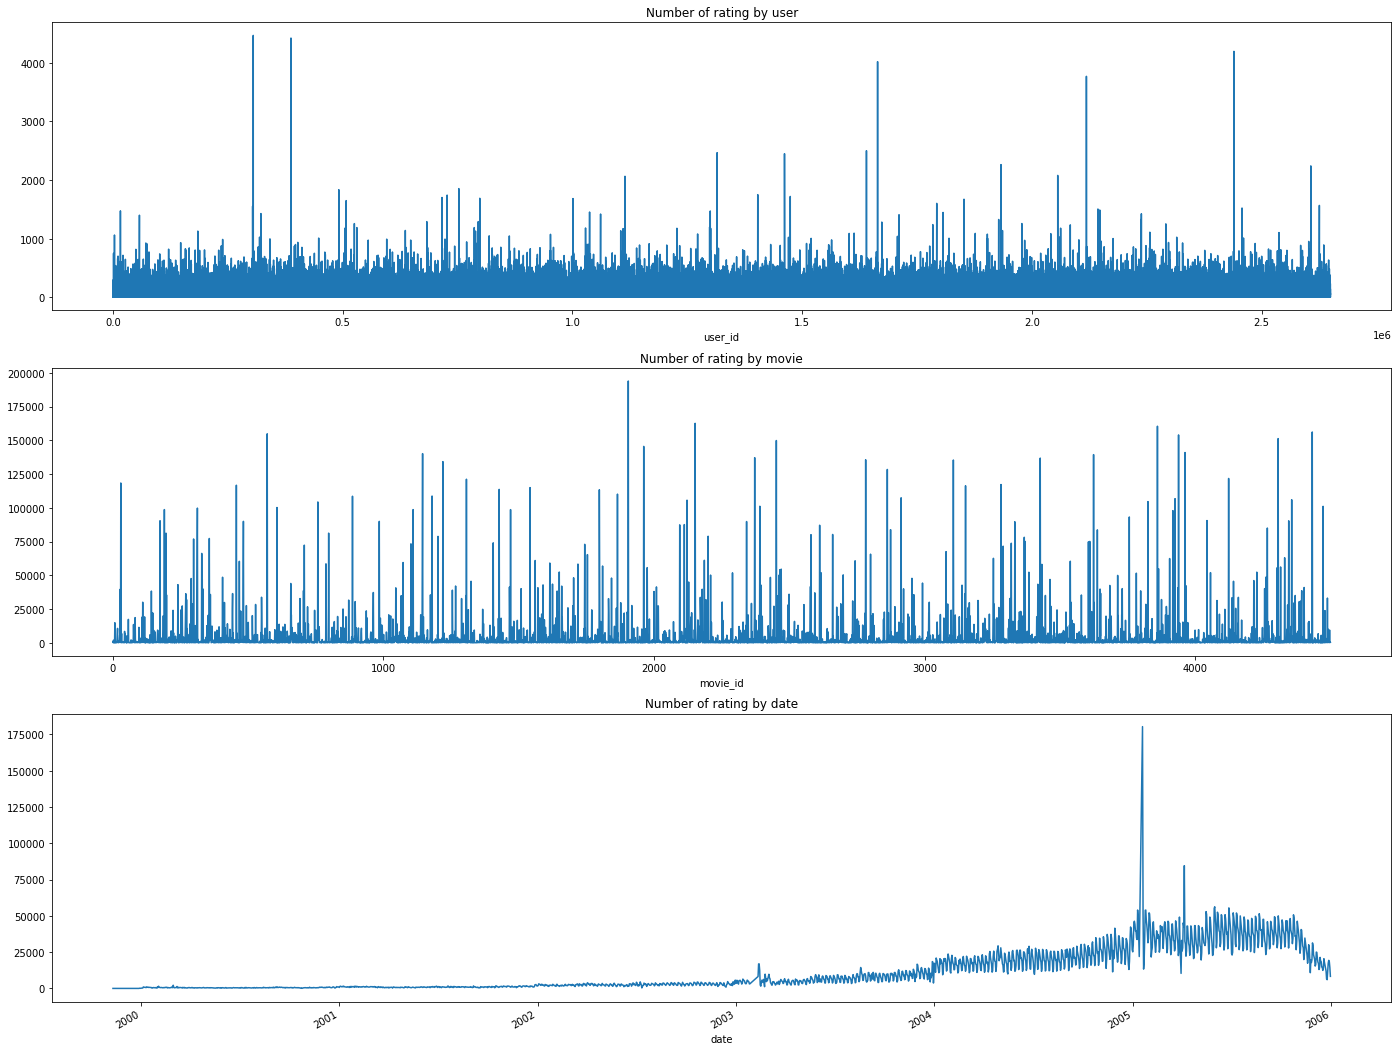

In [25]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(24,20))

user.plot(ax=ax[0])
movie.plot(ax=ax[1])
date.plot(ax=ax[2])

ax[0].set_title('Number of rating by user')
ax[1].set_title('Number of rating by movie')
ax[2].set_title('Number of rating by date')

fig.show()

/Users/stellalam/opt/anaconda3/envs/project3362/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


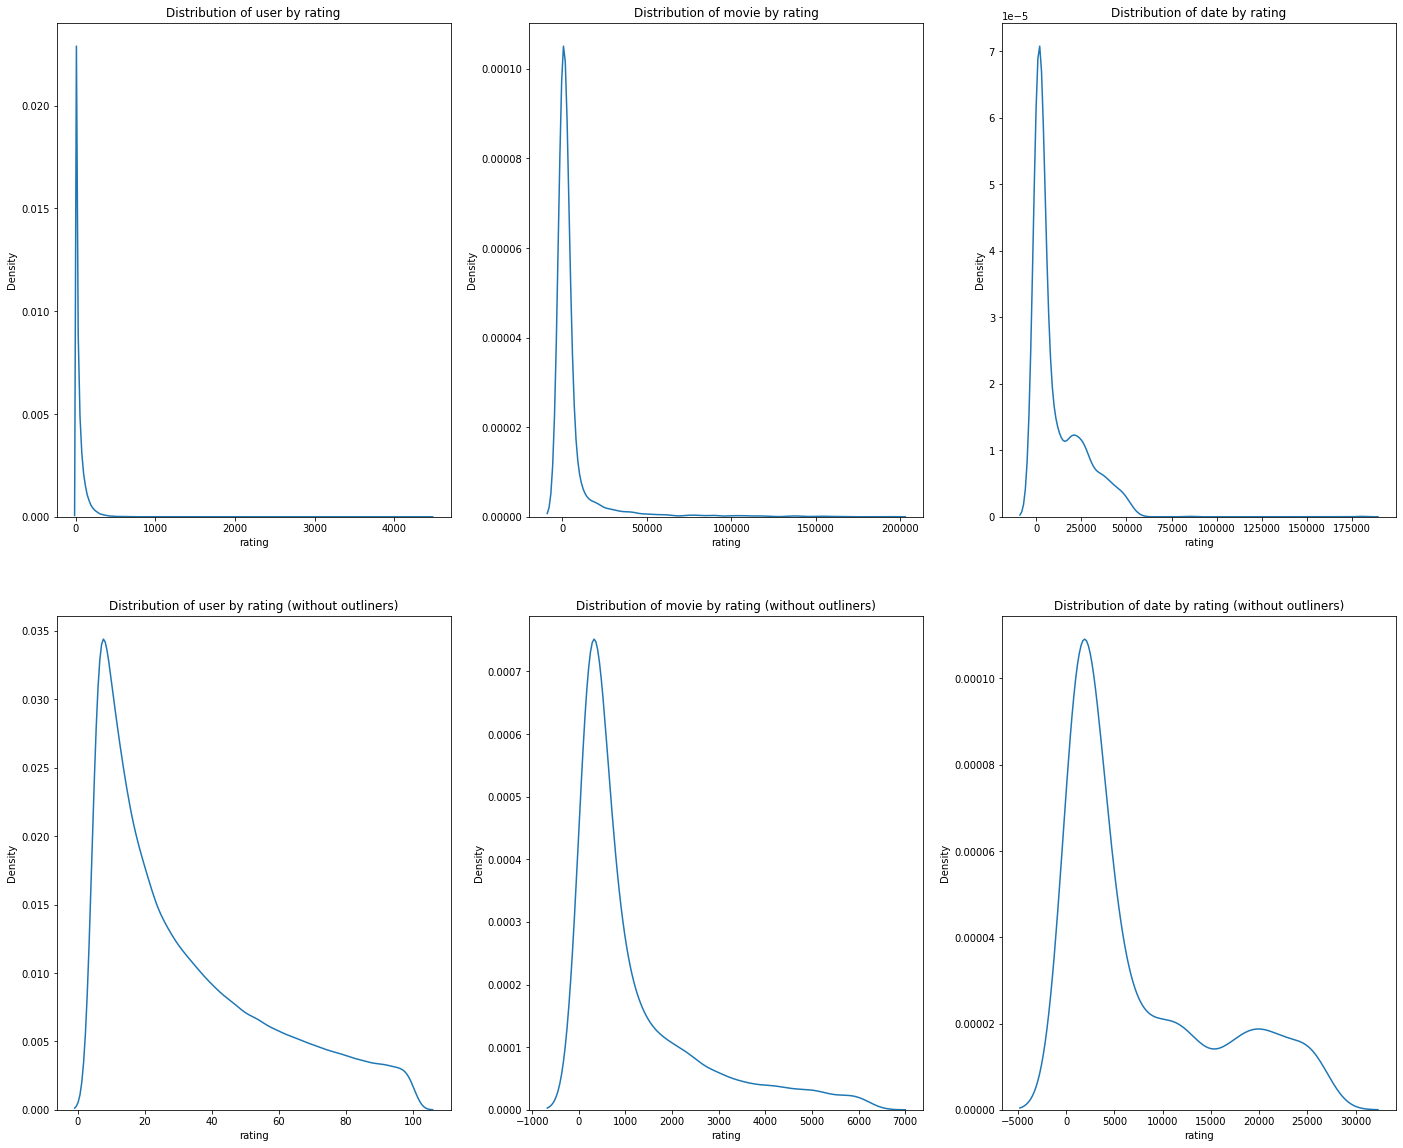

In [26]:

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(24,20))

sns.kdeplot(data=user,ax=ax[0,0])
sns.kdeplot(data=movie,ax=ax[0,1])
sns.kdeplot(data=date,ax=ax[0,2])

sns.kdeplot(data=user[user.between(user.quantile(.15),user.quantile(.85))],ax=ax[1,0])
sns.kdeplot(data=movie[movie.between(movie.quantile(.15),movie.quantile(.85))],ax=ax[1,1])
sns.kdeplot(data=date[date.between(date.quantile(.15),date.quantile(.85))],ax=ax[1,2])

ax[0,0].set_title('Distribution of user by rating')
ax[0,1].set_title('Distribution of movie by rating')
ax[0,2].set_title('Distribution of date by rating')

ax[1,0].set_title('Distribution of user by rating (without outliners)')
ax[1,1].set_title('Distribution of movie by rating (without outliners)')
ax[1,2].set_title('Distribution of date by rating (without outliners)')

fig.show()

In [27]:
# fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(24,20))

# user.plot.box(ax=ax[0,0])
# movie.plot.box(ax=ax[0,1])
# date.plot.box(ax=ax[0,2])

# user[user.between(user.quantile(.15),user.quantile(.85))].plot.box(ax=ax[1,0])
# movie[movie.between(movie.quantile(.15),movie.quantile(.85))].plot.box(ax=ax[1,1])
# date[date.between(date.quantile(.15),date.quantile(.85))].plot.box(ax=ax[1,2])


# ax[0,0].set_title('Box Plot of user by rating')
# ax[0,1].set_title('Box Plot of movie by rating')
# ax[0,2].set_title('Box Plot of date by rating')

# ax[1,0].set_title('Box Plot of user by rating (without outliners)')
# ax[1,1].set_title('Box Plot of movie by rating (without outliners)')
# ax[1,2].set_title('Box Plot of date by rating (without outliners)')

# fig.show()

##### Observations
- We can see that most users rate the movie with score 3 (28.7%), 4 (33.6%), 5 (23.1%).
- Users mostly rates movies within around `0` to `100` times.
- Movies mostly are rated by around `0` to `1500` times.
- Number of rating are increasing from `1999` to `2005` (values are come from the next section)

#### Generating Summaries

In [28]:
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

##### Observations
- There is no null data in the data frame.
- Most of the correlation of each pair of variable are very closed to `0`, and their linear relationships are weak.
- But the `movie_id` and `df_index` are having high correlations. 
- We can see that the movies are having more ratings per date when the date increased.
- Most movies are having ratings `<10000`
- Most users rates movies `<100` times (after removing outliners).
- Newer user / movie does not implies more /lessor ratings.
- Most ratings are `3` and `4` as shown in the percentage graph or summary.
- Ratings are distributed variously as shown in pair plot.